<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

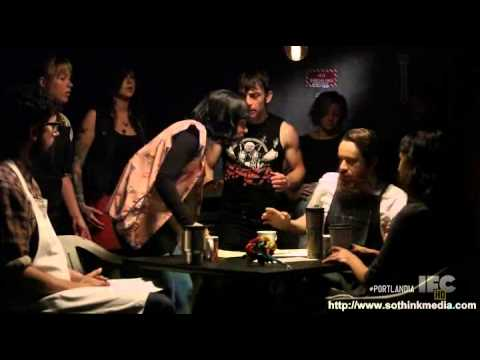

In [9]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [10]:
%pwd

'c:\\Users\\porte\\Richard_python\\lambda\\4lam\\DS-Unit-4-Sprint-1-NLP\\module1-text-data'

In [27]:
import pandas as pd

url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"

shops = pd.read_csv(url)
shops.head(10)

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating
5,The Factory - Cafe With a Soul,11/20/2016 1 check-in Very cute cafe! I think...,4.0 star rating
6,The Factory - Cafe With a Soul,"10/27/2016 2 check-ins Listed in ""Nuptial Cof...",4.0 star rating
7,The Factory - Cafe With a Soul,11/2/2016 2 check-ins Love this place! 5 sta...,5.0 star rating
8,The Factory - Cafe With a Soul,"10/25/2016 1 check-in Ok, let's try this appr...",3.0 star rating
9,The Factory - Cafe With a Soul,11/10/2016 3 check-ins This place has been sh...,5.0 star rating


In [28]:
# Doing the imports for some of the libraries that may need
from collections import Counter

import squarify
import matplotlib.pyplot as plt
import seaborn as sns

import re
from nltk.stem import PorterStemmer
from spacy.tokenizer import Tokenizer
import spacy

In [3]:
# Will try to do some cleaning up of the data before doing analysis
shops["coffee_shop_name"].value_counts()

Epoch Coffee                            400
Halcyon                                 300
The Factory - Cafe With a Soul          244
Venezia Italian Gelato                  200
Houndstooth Coffee                      200
                                       ... 
Lucky Lab Coffee                         25
Sister Coffee                            17
Kowabunga Coffee                         16
The Marvelous Vintage Tea Party Co.      10
Lola Savannah Coffee Downtown             4
Name: coffee_shop_name, Length: 79, dtype: int64

In [4]:
# Looking to see if there are any NAN values in the data
shops.isna().sum()

coffee_shop_name    0
full_review_text    0
star_rating         0
dtype: int64

In [29]:
# Doing some of the cleaning of the columns
# Working on removing the date from the 
# making the function that will remove the date fro the column
def move_date(some_string):
    pattern = r'\b[0-3]?[0-9]/[0-3]?[0-9]/(?:[0-9]{2})?[0-9]{2}\b'
    some_string = str(some_string)
    m = re.search(pattern, some_string)
    return m.group(0)

# This second method will remove the date from the 
# review column
def remove_date(some_string):
    pattern = r"\b[0-3]?[0-9]/[0-3]?[0-9]/(?:[0-9]{2})?[0-9]{2}\b"
    some_string = str(some_string)
    another_string = re.sub(pattern,"", some_string)
    return another_string



In [30]:
shops["review_date"] = shops['full_review_text'].apply(move_date)
shops['full_review_text'] = shops["full_review_text"].apply(remove_date)
shops.head(2)

,coffee_shop_name,full_review_text,star_rating,review_date
0,The Factory - Cafe With a Soul,1 check-in Love love loved the atmosphere! E...,5.0 star rating,11/25/2016
1,The Factory - Cafe With a Soul,"Listed in Date Night: Austin, Ambiance in Au...",4.0 star rating,12/2/2016


In [7]:
shops["star_rating"].dtype

dtype('O')

In [41]:
# now working on removing the words from the star_rating column
def remove_words(some_string):
    some_string = str(some_string)
    some_string = some_string.replace("star rating", "")
    return some_string

In [9]:
m = remove_words(shops["star_rating"])
m

'0        5.0  \n1        4.0  \n2        4.0  \n3        2.0  \n4        4.0  \n              ...        \n7611     4.0  \n7612     5.0  \n7613     4.0  \n7614     3.0  \n7615     4.0  \nName: star_rating, Length: 7616, dtype: object'

In [10]:
shops["star_rating"] = shops['star_rating'].apply(remove_words)
shops.head(2)

,coffee_shop_name,full_review_text,star_rating,review_date
0,The Factory - Cafe With a Soul,1 check-in Love love loved the atmosphere! E...,5.0,11/25/2016
1,The Factory - Cafe With a Soul,"Listed in Date Night: Austin, Ambiance in Au...",4.0,12/2/2016


In [11]:
shops["star_rating"].dtype

dtype('O')

In [31]:
#using spaCy
nlp = spacy.load("en_core_web_lg")
tokenizer = Tokenizer(nlp.vocab)

In [13]:
# Going to use the tokenizer to get the spacy tokens
tokens = []
for doc in tokenizer.pipe(shops["full_review_text"]):
    doc_tokens = [token.text for token in doc]
    tokens.append(doc_tokens)

shops["spacy_tokens"] = tokens
shops.head(3)

,coffee_shop_name,full_review_text,star_rating,review_date,spacy_tokens
0,The Factory - Cafe With a Soul,1 check-in Love love loved the atmosphere! E...,5.0,11/25/2016,"[ , 1, check-in, Love, love, loved, the, atmo..."
1,The Factory - Cafe With a Soul,"Listed in Date Night: Austin, Ambiance in Au...",4.0,12/2/2016,"[ , Listed, in, Date, Night:, Austin,, Ambian..."
2,The Factory - Cafe With a Soul,1 check-in Listed in Brunch Spots I loved th...,4.0,11/30/2016,"[ , 1, check-in, Listed, in, Brunch, Spots, I..."


In [14]:
# using the default stop words list provided by spacy to remove the stop words
tokens = []  # this is the list to add another column on the dataframe

for doc in tokenizer.pipe(shops["full_review_text"]):
    doc_tokens = []
    # running through each doc and removing the stop_words
    for token in doc:
        # Doing a bitwise operation
        if (token.is_stop == False) & (token.is_punct == False):
            doc_tokens.append(token.text.lower())
    tokens.append(doc_tokens)

# Will now add these to the dataframe also
shops["spacy_removed_default_stop"] = tokens
shops.head(2)





,coffee_shop_name,full_review_text,star_rating,review_date,spacy_tokens,spacy_removed_default_stop
0,The Factory - Cafe With a Soul,1 check-in Love love loved the atmosphere! E...,5.0,11/25/2016,"[ , 1, check-in, Love, love, loved, the, atmo...","[ , 1, check-in, love, love, loved, atmospher..."
1,The Factory - Cafe With a Soul,"Listed in Date Night: Austin, Ambiance in Au...",4.0,12/2/2016,"[ , Listed, in, Date, Night:, Austin,, Ambian...","[ , listed, date, night:, austin,, ambiance, ..."


In [15]:
# counting the text
myCounter = Counter()
mCounter = Counter()
shops["spacy_tokens"].apply(lambda x: myCounter.update(x))
shops["spacy_removed_default_stop"].apply(lambda x: mCounter.update(x))
print("The most common words with just spacy\n", myCounter.most_common(30))

print("The most common words with default stop words removed\n", mCounter.most_common(30))


The most common words with just spacy
 [('the', 27779), ('and', 25748), ('a', 22085), ('I', 19780), ('to', 16904), (' ', 15028), ('of', 12495), ('is', 11748), ('was', 9539), ('in', 8901), ('for', 8244), ('  ', 7911), ('coffee', 7315), ('The', 6812), ('it', 6370), ('with', 6103), ('but', 5701), ('that', 5607), ('my', 5004), ('you', 4966), ('on', 4937), ('have', 4909), ('this', 4710), ('are', 4258), ('place', 4233), ('they', 3939), ('so', 3814), ('not', 3471), ('be', 3137), ('their', 3129)]
The most common words with default stop words removed
 [(' ', 15028), ('coffee', 8058), ('  ', 7911), ('place', 4264), ('great', 3250), ("it's", 3117), ('like', 2902), ('good', 2779), ('1', 2035), ('check-in', 1961), ('love', 1806), ("i'm", 1797), ("i've", 1479), ('little', 1479), ("don't", 1395), ('nice', 1368), ('food', 1363), ('time', 1345), ('pretty', 1339), ('got', 1247), ('people', 1223), ('come', 1193), ('austin', 1188), ('best', 1165), ('definitely', 1154), ('friendly', 1145), ('latte', 1124),

In [18]:
first = [x[1] for x in myCounter.most_common(25)]
the_labels = [x[0] for x in myCounter.most_common(25)]

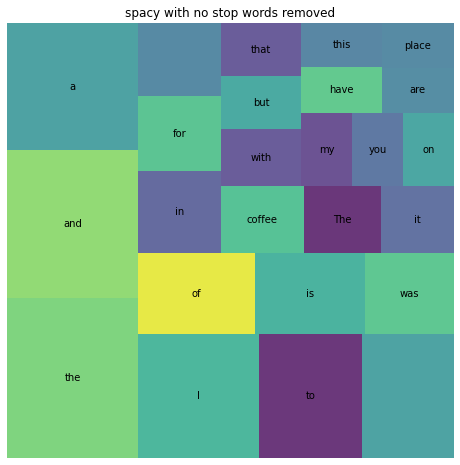

In [22]:
# This is the squarify plot of the most common with the 
# no stop words removed
plt.figure(figsize=(8,8))
squarify.plot(sizes=first, label=the_labels, alpha=.8)
plt.axis("off")
plt.title("spacy with no stop words removed")
plt.show()

In [23]:
# this is removing the stop words
first = [x[1] for x in mCounter.most_common(25)]
the_labels = [x[0] for x in mCounter.most_common(25)]

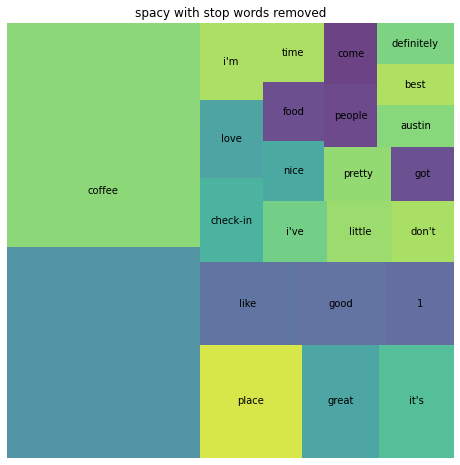

In [24]:
# Doing the plot with the stop words removed in the default
plt.figure(figsize=(8,8))
squarify.plot(sizes=first, label=the_labels, alpha=.8)
plt.axis("off")
plt.title("spacy with stop words removed")
plt.show()

In [36]:
# Will be adding some new words to the list of stop words to get rid of a few of the things that don't make sense
STOP_WORDS = nlp.Defaults.stop_words.union([" ", "  ", "1", "i've", "i'm", "it's", 'coffee.','coffee', 'check-in', "check-ins", 
                                            "don't" , "come", "like" ])

In [6]:
# importing this to get a progress bar
from tqdm import tqdm


In [7]:
tqdm.pandas()

C:\Users\porte\Anaconda3\envs\lam4-nlp-s1\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [58]:
# removing the extra stop words

tokens = []  # this is the list to add another column on the dataframe

for doc in tokenizer.pipe(shops["full_review_text"]):
    doc_tokens = []
    # running through each doc and removing the stop_words
    for token in doc:
        # Doing a bitwise operation
        if (token.text.lower() not in STOP_WORDS) & (token.is_punct == False):
            doc_tokens.append(token.text.lower())
    tokens.append(doc_tokens)

# Will now add these to the dataframe also
shops["spacy_removed_extra_stop"] = tokens
shops.head(2)


,coffee_shop_name,full_review_text,star_rating,review_date,spacy_tokens,spacy_removed_default_stop,spacy_removed_extra_stop
0,The Factory - Cafe With a Soul,1 check-in Love love loved the atmosphere! E...,5.0,11/25/2016,"[ , 1, check-in, Love, love, loved, the, atmo...","[ , 1, check-in, love, love, loved, atmospher...","[love, love, loved, atmosphere!, corner, shop,..."
1,The Factory - Cafe With a Soul,"Listed in Date Night: Austin, Ambiance in Au...",4.0,12/2/2016,"[ , Listed, in, Date, Night:, Austin,, Ambian...","[ , listed, date, night:, austin,, ambiance, ...","[listed, date, night:, austin,, ambiance, aust..."


In [59]:
# Getting the most common for the tokens of removng the extra stops
the_counter = Counter()
shops["spacy_removed_extra_stop"].apply(lambda x: the_counter.update(x))
print("Building the counter for the squairfy plot")

Building the counter for the squairfy plot


In [60]:
theLabels = [x[0] for x in the_counter.most_common(25)]
theSizes = [x[1] for x in the_counter.most_common(25)]

In [61]:
theLabels


['place',
 'great',
 'good',
 'love',
 'little',
 'nice',
 'food',
 'time',
 'pretty',
 'got',
 'people',
 'austin',
 'best',
 'definitely',
 'friendly',
 'latte',
 'shop',
 'iced',
 'try',
 'work',
 'tea',
 'staff',
 'service',
 'parking',
 'coffee,']

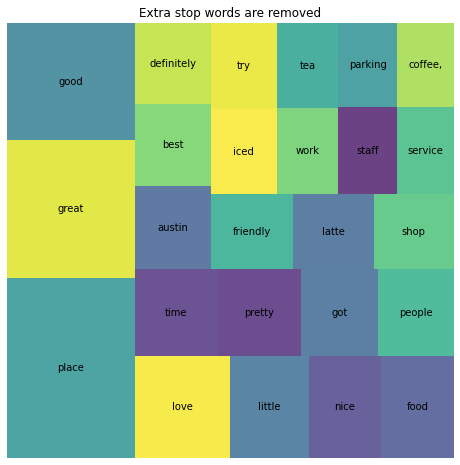

In [62]:
# Will now do the visualization for removing the extra stop words
plt.figure(figsize=(8,8))
squarify.plot(sizes=theSizes, label=theLabels, alpha=.8)
plt.axis("off")
plt.title("Extra stop words are removed")
plt.show()


In [ ]:
# Will do lemmitization to make words that are similar to become just one word
# doing the full pipeline


In [37]:
# Making the function to the lemmatization
def make_lemma(text):
    lemma_list = []
    doc = nlp(text)
    for token in doc:
        if (token.text.lower() not in STOP_WORDS) and (token.is_punct == False) and (token.is_digit == False) and (token.pos_ != "PRON") and (token):
            lemma_list.append(token.lemma_)
    return lemma_list

In [38]:
shops["spacy_lemma"] = shops["full_review_text"].apply(make_lemma)


In [39]:
print(shops.iloc[0]["spacy_lemma"])

['check', 'Love', 'love', 'love', 'atmosphere', 'corner', 'shop', 'style', 'swing', 'order', 'matcha', 'latte', 'muy', 'fantastico', 'order', 'get', 'drink', 'pretty', 'streamlined', 'order', 'iPad', 'include', 'beverage', 'selection', 'range', 'wine', 'desire', 'level', 'sweetness', 'checkout', 'system', 'get', 'latte', 'minute', 'hope', 'typical', 'heart', 'feather', 'latte', 'find', 'list', 'possibility', 'art', 'idea']


In [ ]:
# making a new counter for the those that are 5 star ratings

## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


In [50]:
#Doing the visualization of the two different rankings of 5 Star and 1 star 
shops["star_rating"] = shops['star_rating'].apply(remove_words)
shops["star_rating"] = shops["star_rating"].str.strip()
shops.head(1)

,coffee_shop_name,full_review_text,star_rating,review_date,spacy_lemma
0,The Factory - Cafe With a Soul,1 check-in Love love loved the atmosphere! E...,5.0,11/25/2016,"[check, Love, love, love, atmosphere, corner, ..."


In [51]:
shops["star_rating"].value_counts()

5.0    3780
4.0    2360
3.0     738
2.0     460
1.0     278
Name: star_rating, dtype: int64

In [52]:
#Breaking up into the different groups and show the most common words
fiveStar = shops[shops["star_rating"] == "5.0"]
fourStar = shops[shops["star_rating"] == "4.0"]
threeStar = shops[shops["star_rating"] == "3.0"]
twoStar = shops[shops["star_rating"] == "2.0"]
oneStar = shops[shops["star_rating"] == "1.0"]
fiveStar.shape ,fourStar.shape, threeStar.shape, twoStar.shape, oneStar.shape

((3780, 5), (2360, 5), (738, 5), (460, 5), (278, 5))

In [53]:
# making an function that will make a counter and then count the occurences of the 
# the column asked for
def get_counter(dataFrame, colName):
    # instanciating the column
    counter = Counter()
    dataFrame[colName].apply(lambda x: counter.update(x))
    return counter

In [55]:
five = get_counter(fiveStar, "spacy_lemma")
four = get_counter(fourStar, "spacy_lemma")
three = get_counter(threeStar, "spacy_lemma")
two = get_counter(twoStar, "spacy_lemma")
one = get_counter(oneStar, "spacy_lemma")

In [57]:
# getting the info to do the squarify plot
the_list = [five, 
            four ,
            three,
            two,
            one]
names = ["fiveStar words", "four star words", "three star words", "two star words", "one star words"]

In [62]:
# Getting the most common for 10 words
most_common_label = []
most_common_size = []
for count in the_list:
    most_common_label.append([x[0] for x in count.most_common(10)])
    most_common_size.append([x[1] for x in count.most_common(10)])


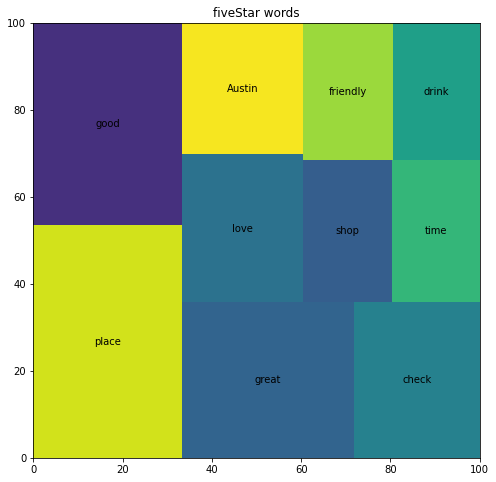

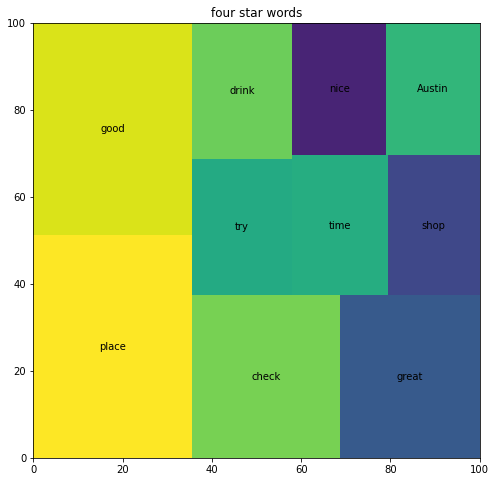

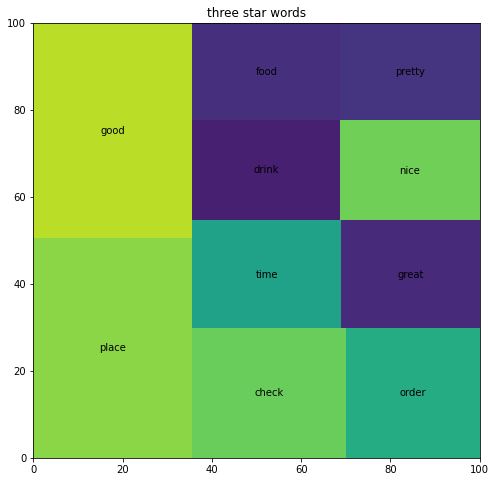

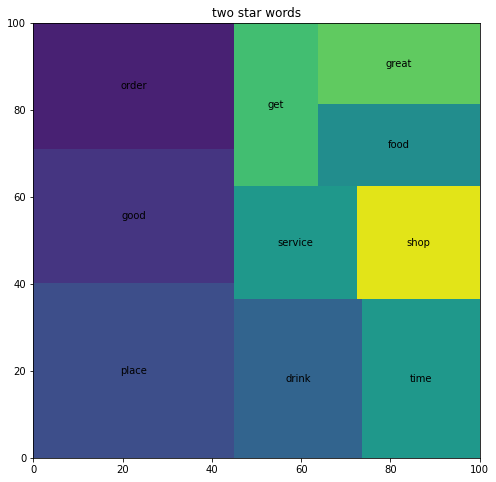

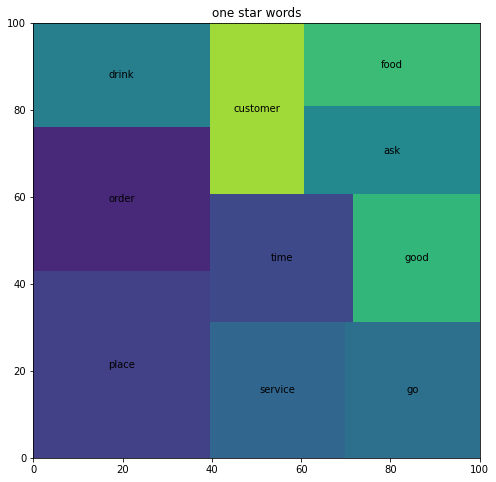

In [71]:
#fig, ax = plt.subplots(3, 2)
#plt.figure(figsize=(5,5))
# Doing a for loop with the info 
for i in range(0, len(the_list)):
    plt.figure(figsize=(8,8))
    squarify.plot(label=most_common_label[i], sizes=most_common_size[i])
    plt.title(names[i])
    plt.show()


## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

